In [1]:
# !pip install ipython-autotime 

In [2]:
%load_ext autotime
# %unload_ext autotime

time: 188 µs (started: 2022-08-20 09:13:33 +00:00)


In [3]:
%load_ext autoreload
%autoreload 2
import dpp
import matplotlib.pyplot as plt
import numpy as np
import torch
from copy import deepcopy
from dpp.metrics import aggregate_loss_over_dataloader, sampling_plot
torch.set_default_tensor_type(torch.cuda.FloatTensor)

time: 1.38 s (started: 2022-08-20 09:13:33 +00:00)


In [4]:
print('torch.__version__', torch.__version__)
print('torch.cuda.is_available', torch.cuda.is_available())
print('torch.cuda.device_count', torch.cuda.device_count())    
print('torch.cuda.current_device', torch.cuda.current_device())  

torch.__version__ 1.11.0
torch.cuda.is_available True
torch.cuda.device_count 1
torch.cuda.current_device 0
time: 37.1 ms (started: 2022-08-20 09:13:34 +00:00)


In [5]:
# Config
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

time: 20.4 ms (started: 2022-08-20 09:13:34 +00:00)


In [6]:
# Training config
regularization = 1e-5  # L2 regularization parameter
learning_rate = 1e-3   # Learning rate for Adam optimizer
max_epochs = 1000      # For how many epochs to train
display_step = 5       # Display training statistics after every display_step
patience = 50          # After how many consecutive epochs without improvement of val loss to stop training

time: 12.5 ms (started: 2022-08-20 09:13:34 +00:00)


In [7]:
def load_data(params):
    dataset_name = params['dataset_name']
    time_scale = params['time_scale']
    batch_size = params['batch_size']
    
    dataset = dpp.data.load_dataset(dataset_name, time_scale=time_scale)
    d_train, d_val, d_test = dataset.train_val_test_split(seed=seed)

    dl_train = d_train.get_dataloader(batch_size=batch_size, shuffle=True)
    dl_val = d_val.get_dataloader(batch_size=batch_size, shuffle=False)
    dl_test = d_test.get_dataloader(batch_size=batch_size, shuffle=False)
    
    return dataset, d_train, d_val, d_test, dl_train, dl_val, dl_test

def build_model(d_train, params):
    
    context_size = params['context_size']
    mark_embedding_size = params['mark_embedding_size']
    rnn_type = params['rnn_type']
    num_mix_components = params['num_mix_components']
    
    mean_log_inter_time, std_log_inter_time = d_train.get_inter_time_statistics()

    model = dpp.models.LogNormMix(
        num_marks=d_train.num_marks,
        mean_log_inter_time=mean_log_inter_time,
        std_log_inter_time=std_log_inter_time,
        context_size=context_size,
        mark_embedding_size=mark_embedding_size,
        rnn_type=rnn_type,
        num_mix_components=num_mix_components,
    )
    
    return model

def train_helper(model, dl_train, dl_val):
    opt = torch.optim.Adam(model.parameters(), weight_decay=regularization, lr=learning_rate)

    impatient = 0
    best_loss = np.inf
    best_model = deepcopy(model.state_dict())
    training_val_losses = []

    for epoch in range(max_epochs):
        model.train()
        for batch in dl_train:
            opt.zero_grad()
            tot_nll, _, _, _, _ = model.log_prob(batch)
            loss = -tot_nll.mean()
            loss.backward()
            opt.step()

        model.eval()
        with torch.no_grad():
            loss_val = aggregate_loss_over_dataloader(model, dl_val)
            training_val_losses.append(loss_val)

        if (best_loss - loss_val) < 1e-4:
            impatient += 1
            if loss_val < best_loss:
                best_loss = loss_val
                best_model = deepcopy(model.state_dict())
        else:
            best_loss = loss_val
            best_model = deepcopy(model.state_dict())
            impatient = 0

        if impatient >= patience:
            print(f'Breaking due to early stopping at epoch {epoch}')
            break

        if epoch % display_step == 0:
            print(f"Epoch {epoch:4d}: loss_train_last_batch = {loss.item():.1f}, loss_val = {loss_val:.1f}, , p_e = {impatient}")
            
    return best_model

def evaluation(model, dl_train, dl_val, dl_test):
    model.eval()

    # All training & testing sequences stacked into a single batch
    with torch.no_grad():
        print('TRAIN')
        _ = aggregate_loss_over_dataloader(model, dl_train, eval_mode=True)
        print('-'*30)
        print('VAL')
        _ = aggregate_loss_over_dataloader(model, dl_val, eval_mode=True)
        print('-'*30)
        print('TEST')
        _ = aggregate_loss_over_dataloader(model, dl_test, eval_mode=True)
        

time: 13.1 ms (started: 2022-08-20 09:13:34 +00:00)


In [8]:
def train_dataset(params):
    print(params['dataset_name'])
    print('-'*50)
    print('Loading data..')
    dataset, d_train, d_val, d_test, dl_train, dl_val, dl_test = load_data(params)
    print('-'*50)
    print('Building model..')
    model = build_model(d_train, params)  
    print('-'*50)
    print('Loading model..')
    model_load_path = '/home/jovyan/drive1/others/ifl-tpp/models/{}.pth'.format(dataset_name.split('/')[-1])
    print(model_load_path)
    model = torch.load(model_load_path)
    print('-'*50)
    print('Evaluation..')
    evaluation(model, dl_train, dl_val, dl_test)
    print('-'*50)
    print('Sampling..')
    sampling_plot(model, t_end, num_seq, dataset)

time: 12.3 ms (started: 2022-08-20 09:13:34 +00:00)


### Hawkes Ind.

synth/hawkes_ind
--------------------------------------------------
Loading data..
--------------------------------------------------
Building model..
--------------------------------------------------
Loading model..
/home/jovyan/drive1/others/ifl-tpp/models/hawkes_ind.pth
--------------------------------------------------
Evaluation..
TRAIN
Time_NLL       : 47.2226
Mark_NLL       : 11.6033
NLL            : 59.8394
NLL/TIME       : 0.6924
f1_micro (Acc) : 70.3799
f1_macro       : 56.4623
f1_weighted    : 64.6018
------------------------------
VAL
Time_NLL       : 47.3126
Mark_NLL       : 11.6277
NLL            : 59.9608
NLL/TIME       : 0.6934
f1_micro (Acc) : 70.2456
f1_macro       : 56.2873
f1_weighted    : 64.4360
------------------------------
TEST
Time_NLL       : 47.1918
Mark_NLL       : 11.5722
NLL            : 59.7945
NLL/TIME       : 0.6936
f1_micro (Acc) : 70.5682
f1_macro       : 56.5191
f1_weighted    : 64.8005
--------------------------------------------------
Sampling..


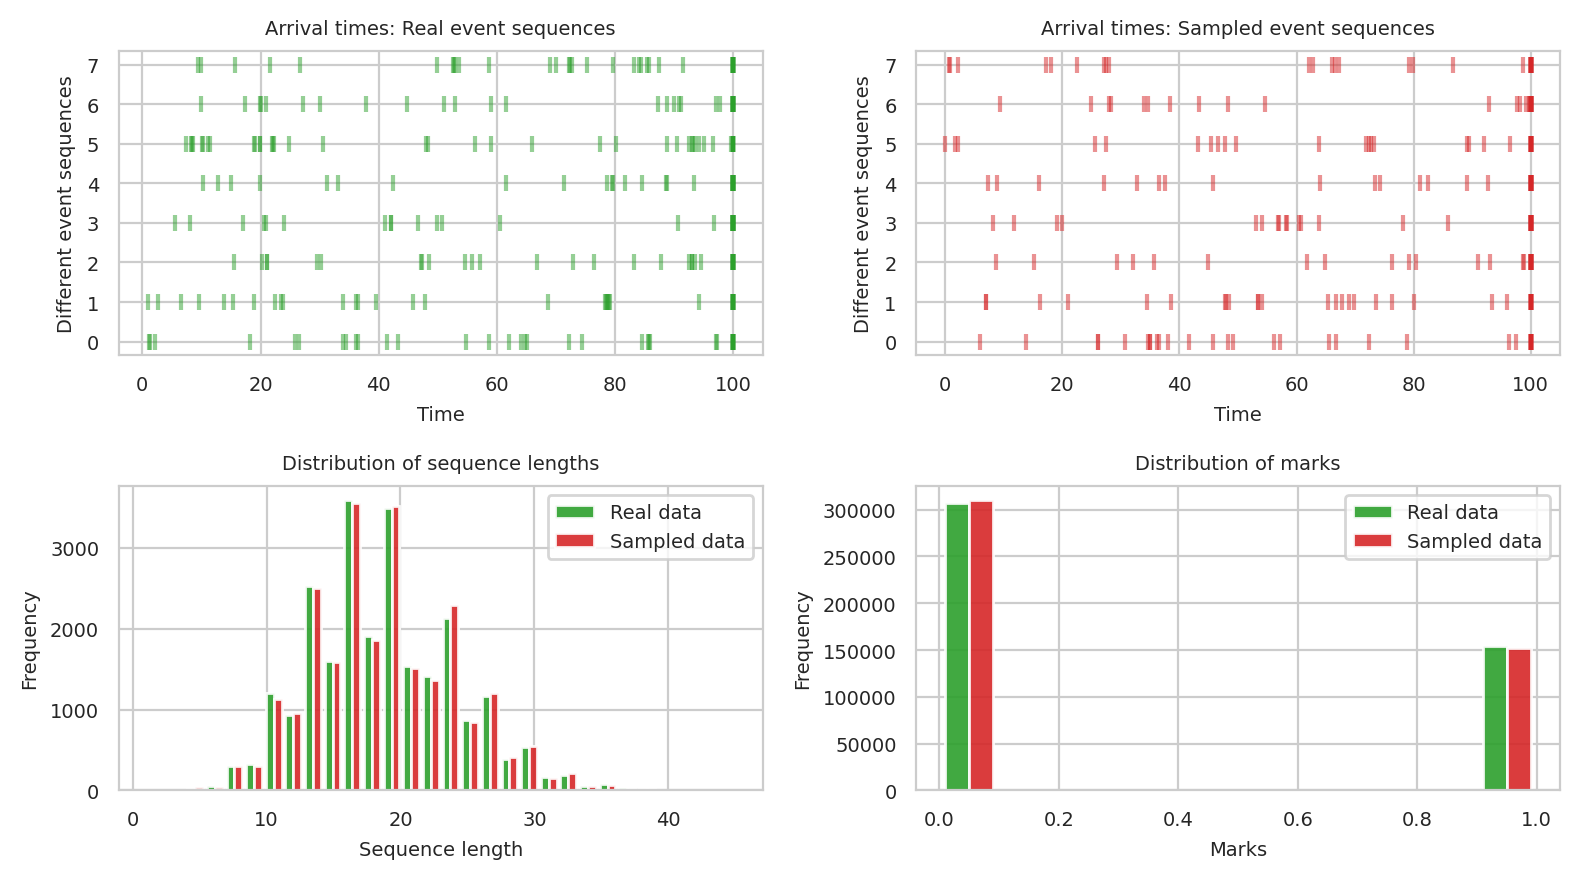

time: 1min 16s (started: 2022-08-20 09:13:34 +00:00)


In [9]:
dataset_name = 'synth/hawkes_ind' 

batch_size = 512                   # Number of sequences in a batch
num_mix_components = 64            # Number of components for a mixture model
context_size = 64                  # Size of the RNN hidden vector
mark_embedding_size = 32           # Size of the mark embedding (used as RNN input)
rnn_type = "GRU"                   # What RNN to use as an encoder {"RNN", "GRU", "LSTM"}
time_scale = 1.0

# Sampling parameters Hawkes Dep
num_seq = 24576
t_start = 0 * time_scale
t_end = 100 * time_scale
t_end = t_end - t_start

params = {
            'dataset_name': dataset_name,
            'batch_size': batch_size, 
            'num_mix_components': num_mix_components,
            'context_size': context_size,
            'mark_embedding_size': mark_embedding_size,
            'rnn_type': rnn_type,
            'time_scale': time_scale,
            'num_seq': num_seq,
            't_end': t_end
        }

train_dataset(params)

### Hawkes Dep. I

synth/hawkes_dep_I
--------------------------------------------------
Loading data..
--------------------------------------------------
Building model..
--------------------------------------------------
Loading model..
/home/jovyan/drive1/others/ifl-tpp/models/hawkes_dep_I.pth
--------------------------------------------------
Evaluation..
TRAIN
Time_NLL       : 52.8840
Mark_NLL       : 16.8461
NLL            : 70.8408
NLL/TIME       : 0.8164
f1_micro (Acc) : 60.1220
f1_macro       : 57.3013
f1_weighted    : 58.5061
------------------------------
VAL
Time_NLL       : 53.1905
Mark_NLL       : 16.9033
NLL            : 71.1865
NLL/TIME       : 0.8185
f1_micro (Acc) : 60.0505
f1_macro       : 57.1751
f1_weighted    : 58.4380
------------------------------
TEST
Time_NLL       : 53.1497
Mark_NLL       : 16.9399
NLL            : 71.2059
NLL/TIME       : 0.8226
f1_micro (Acc) : 59.7762
f1_macro       : 56.9406
f1_weighted    : 58.1696
--------------------------------------------------
Samplin

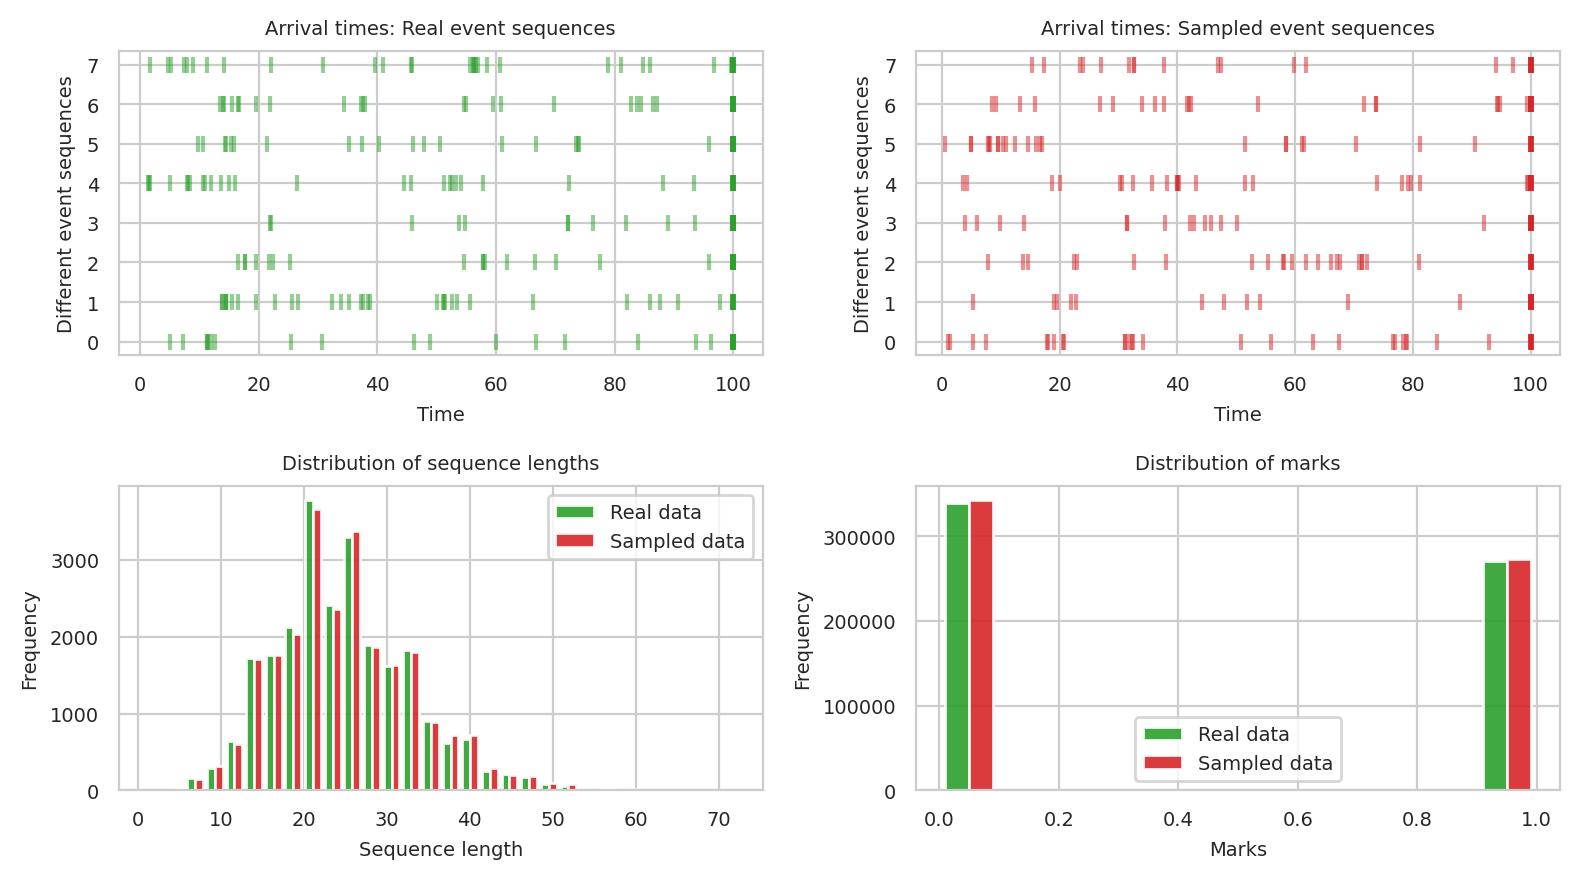

time: 1min 32s (started: 2022-08-20 09:14:51 +00:00)


In [10]:
dataset_name = 'synth/hawkes_dep_I' 

batch_size = 512                   # Number of sequences in a batch
num_mix_components = 64            # Number of components for a mixture model
context_size = 64                  # Size of the RNN hidden vector
mark_embedding_size = 32           # Size of the mark embedding (used as RNN input)
rnn_type = "GRU"                   # What RNN to use as an encoder {"RNN", "GRU", "LSTM"}
time_scale = 1.0

# Sampling parameters Hawkes Dep
num_seq = 24576
t_start = 0 * time_scale
t_end = 100 * time_scale
t_end = t_end - t_start

params = {
            'dataset_name': dataset_name,
            'batch_size': batch_size, 
            'num_mix_components': num_mix_components,
            'context_size': context_size,
            'mark_embedding_size': mark_embedding_size,
            'rnn_type': rnn_type,
            'time_scale': time_scale,
            'num_seq': num_seq,
            't_end': t_end
        }

train_dataset(params)

### Hawkes Dep. II

synth/hawkes_dep_II
--------------------------------------------------
Loading data..
--------------------------------------------------
Building model..
--------------------------------------------------
Loading model..
/home/jovyan/drive1/others/ifl-tpp/models/hawkes_dep_II.pth
--------------------------------------------------
Evaluation..
TRAIN
Time_NLL       : -240.8899
Mark_NLL       : 628.8311
NLL            : 389.2639
NLL/TIME       : 3.9243
f1_micro (Acc) : 33.2214
f1_macro       : 18.4615
f1_weighted    : 26.3820
------------------------------
VAL
Time_NLL       : -240.1714
Mark_NLL       : 628.1125
NLL            : 389.2738
NLL/TIME       : 3.9245
f1_micro (Acc) : 33.1867
f1_macro       : 18.4042
f1_weighted    : 26.3417
------------------------------
TEST
Time_NLL       : -240.8969
Mark_NLL       : 628.7123
NLL            : 389.1157
NLL/TIME       : 3.9227
f1_micro (Acc) : 33.1860
f1_macro       : 18.4242
f1_weighted    : 26.3715
--------------------------------------------

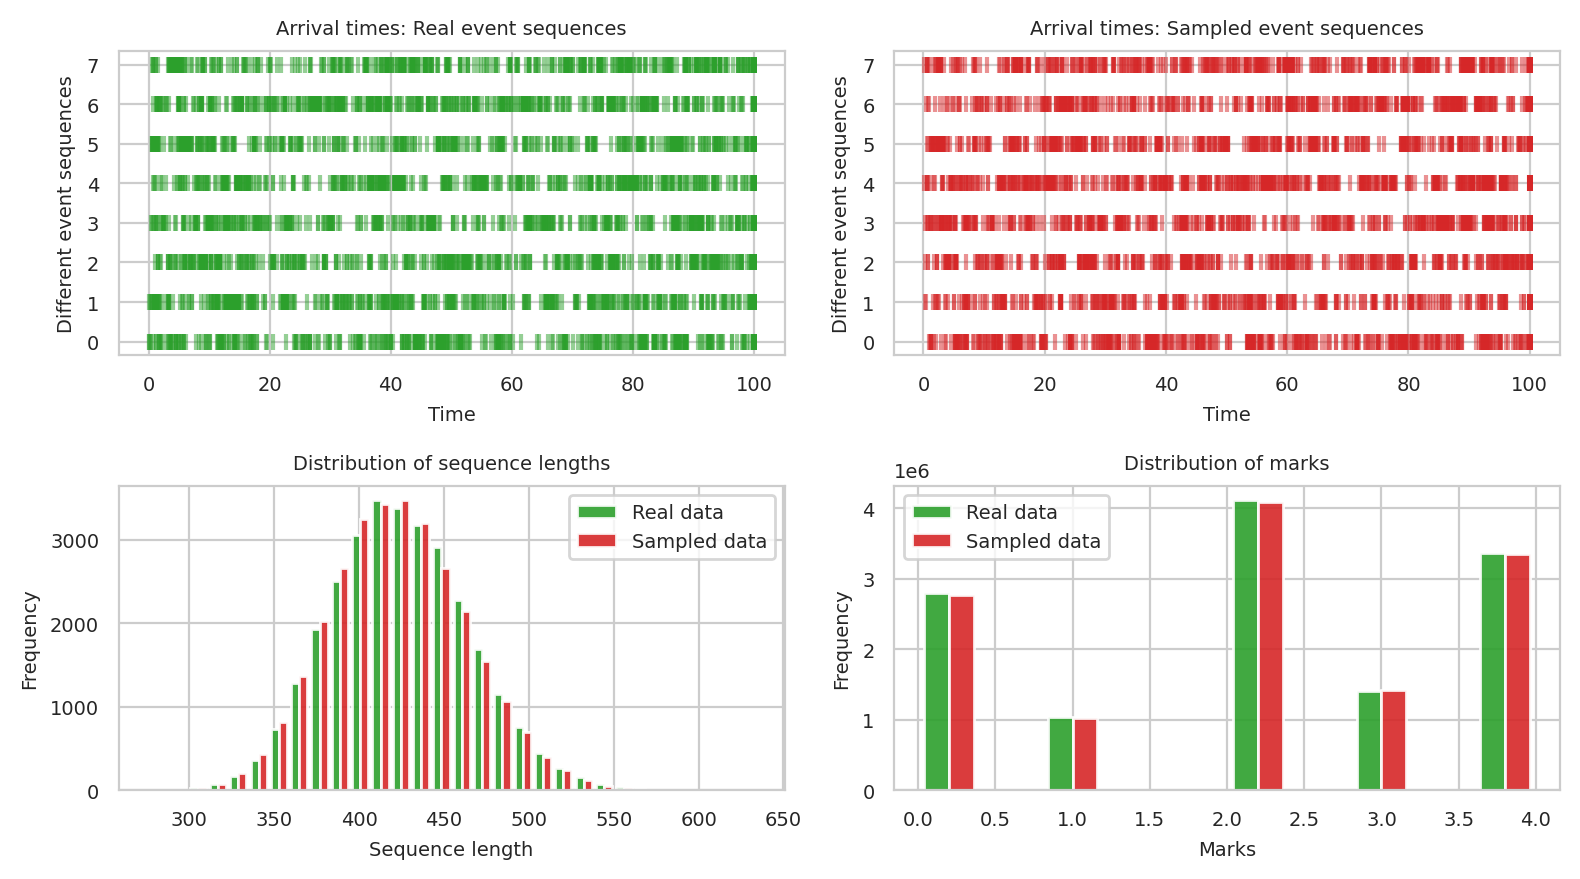

time: 29min 47s (started: 2022-08-20 09:16:23 +00:00)


In [11]:
dataset_name = 'synth/hawkes_dep_II' 

batch_size = 512                   # Number of sequences in a batch
num_mix_components = 64            # Number of components for a mixture model
context_size = 64                  # Size of the RNN hidden vector
mark_embedding_size = 32           # Size of the mark embedding (used as RNN input)
rnn_type = "GRU"                   # What RNN to use as an encoder {"RNN", "GRU", "LSTM"}
time_scale = 1.0

# Sampling parameters Hawkes Dep
num_seq = 30000
t_start = 0 * time_scale
t_end = 100 * time_scale
t_end = t_end - t_start

params = {
            'dataset_name': dataset_name,
            'batch_size': batch_size, 
            'num_mix_components': num_mix_components,
            'context_size': context_size,
            'mark_embedding_size': mark_embedding_size,
            'rnn_type': rnn_type,
            'time_scale': time_scale,
            'num_seq': num_seq,
            't_end': t_end
        }

train_dataset(params)

### Mimic II

real/mimic_ii
--------------------------------------------------
Loading data..
--------------------------------------------------
Building model..
--------------------------------------------------
Loading model..
/home/jovyan/drive1/others/ifl-tpp/models/mimic_ii.pth
--------------------------------------------------
Evaluation..
TRAIN
Time_NLL       : -22.6046
Mark_NLL       : 4.4963
NLL            : -17.4086
NLL/TIME       : -35.6091
f1_micro (Acc) : 72.5888
f1_macro       : 51.7427
f1_weighted    : 71.3120
------------------------------
VAL
Time_NLL       : -21.2233
Mark_NLL       : 4.7163
NLL            : -15.7359
NLL/TIME       : -35.7745
f1_micro (Acc) : 68.1275
f1_macro       : 34.9548
f1_weighted    : 65.1902
------------------------------
TEST
Time_NLL       : -21.0501
Mark_NLL       : 5.7436
NLL            : -14.4641
NLL/TIME       : -31.6496
f1_micro (Acc) : 67.1233
f1_macro       : 25.1621
f1_weighted    : 64.0879
--------------------------------------------------
Samplin

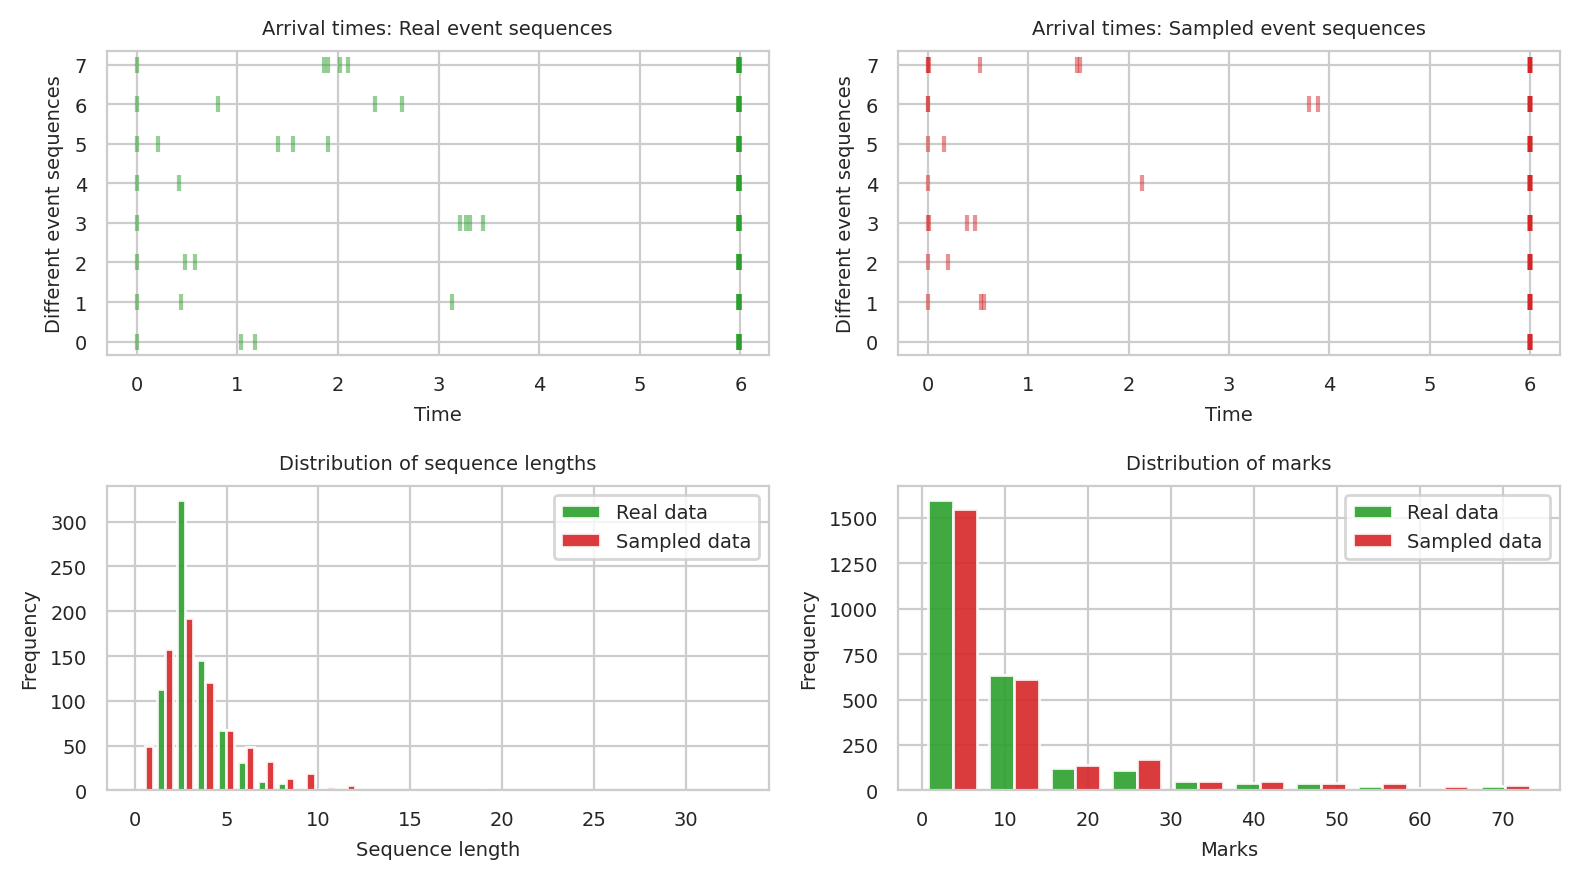

time: 1.47 s (started: 2022-08-20 09:46:11 +00:00)


In [12]:
dataset_name = 'real/mimic_ii' 

batch_size = 64                   # Number of sequences in a batch
num_mix_components = 64            # Number of components for a mixture model
context_size = 64                  # Size of the RNN hidden vector
mark_embedding_size = 32           # Size of the mark embedding (used as RNN input)
rnn_type = "GRU"                   # What RNN to use as an encoder {"RNN", "GRU", "LSTM"}
time_scale = 1.0

# Sampling parameters Hawkes Dep
num_seq = 715
t_start = 0 * time_scale
t_end = 6 * time_scale
t_end = t_end - t_start

params = {
            'dataset_name': dataset_name,
            'batch_size': batch_size, 
            'num_mix_components': num_mix_components,
            'context_size': context_size,
            'mark_embedding_size': mark_embedding_size,
            'rnn_type': rnn_type,
            'time_scale': time_scale,
            'num_seq': num_seq,
            't_end': t_end
        }

train_dataset(params)

### MOOC

real/mooc
--------------------------------------------------
Loading data..
--------------------------------------------------
Building model..
--------------------------------------------------
Loading model..
/home/jovyan/drive1/others/ifl-tpp/models/mooc.pth
--------------------------------------------------
Evaluation..
TRAIN
Time_NLL       : 317.5442
Mark_NLL       : 97.6129
NLL            : 416.6537
NLL/TIME       : 0.0319
f1_micro (Acc) : 58.8139
f1_macro       : 61.6576
f1_weighted    : 57.8243
------------------------------
VAL
Time_NLL       : 324.1195
Mark_NLL       : 96.0160
NLL            : 421.8245
NLL/TIME       : 0.0292
f1_micro (Acc) : 55.7166
f1_macro       : 54.6273
f1_weighted    : 54.6986
------------------------------
TEST
Time_NLL       : 328.7629
Mark_NLL       : 98.4096
NLL            : 428.8084
NLL/TIME       : 0.0287
f1_micro (Acc) : 56.1082
f1_macro       : 55.1202
f1_weighted    : 55.0784
--------------------------------------------------
Sampling..


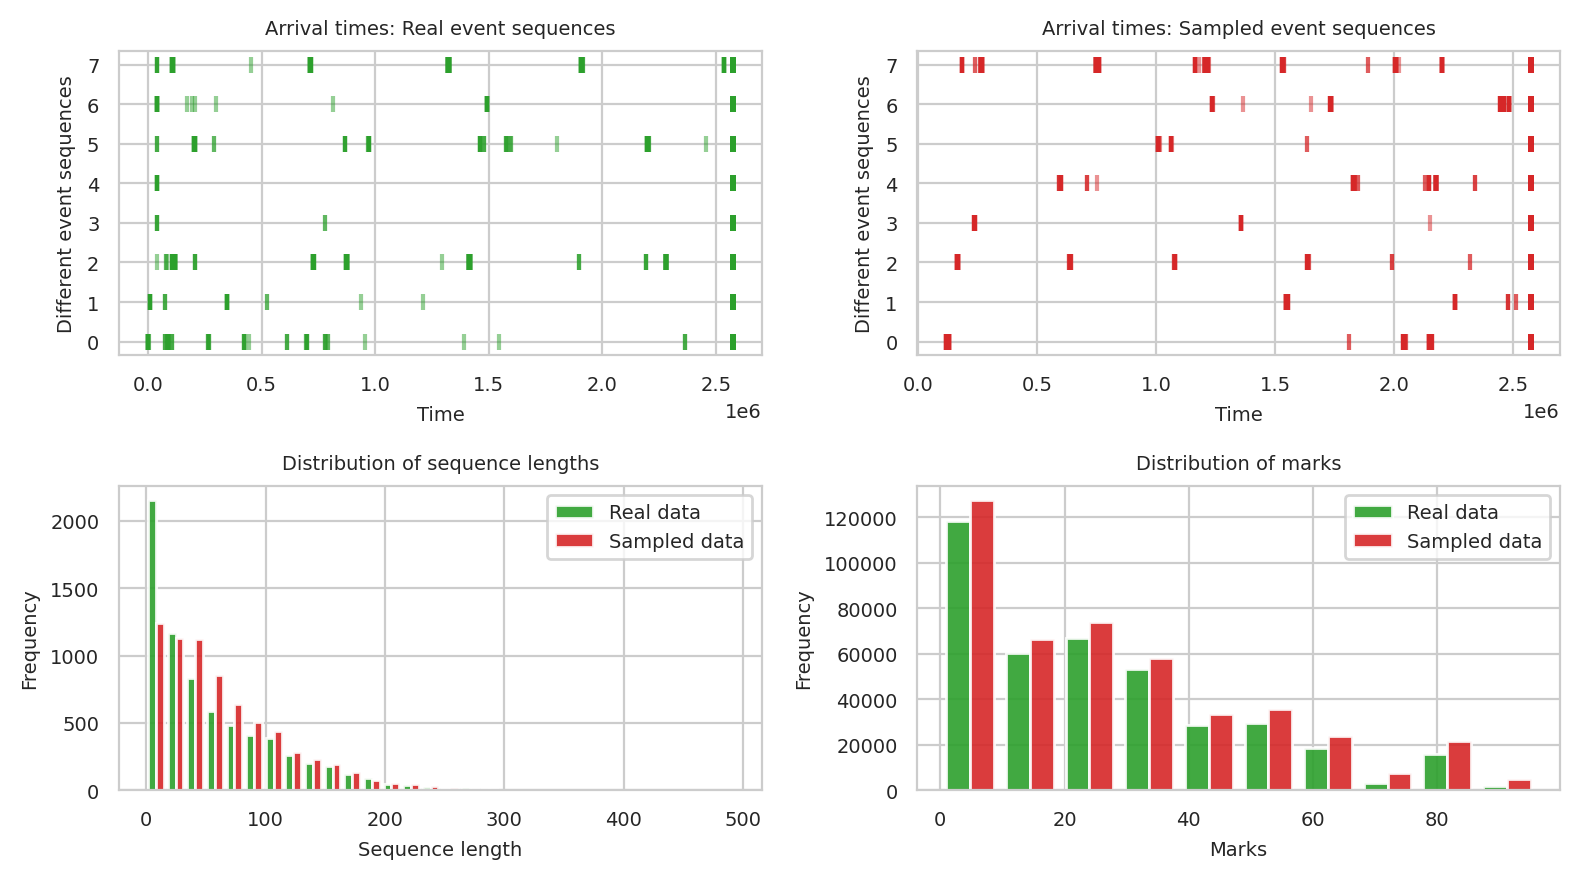

time: 1min 9s (started: 2022-08-20 09:46:12 +00:00)


In [13]:
dataset_name = 'real/mooc' 

batch_size = 64                   # Number of sequences in a batch
num_mix_components = 64            # Number of components for a mixture model
context_size = 64                  # Size of the RNN hidden vector
mark_embedding_size = 64           # Size of the mark embedding (used as RNN input)
rnn_type = "GRU"                   # What RNN to use as an encoder {"RNN", "GRU", "LSTM"}
time_scale = 1.0

# Sampling parameters Hawkes Dep
num_seq = 7047
t_start = 0 * time_scale
t_end = 2573000 * time_scale
t_end = t_end - t_start

params = {
            'dataset_name': dataset_name,
            'batch_size': batch_size, 
            'num_mix_components': num_mix_components,
            'context_size': context_size,
            'mark_embedding_size': mark_embedding_size,
            'rnn_type': rnn_type,
            'time_scale': time_scale,
            'num_seq': num_seq,
            't_end': t_end
        }

train_dataset(params)

### Stack Overflow

real/stack_overflow
--------------------------------------------------
Loading data..
--------------------------------------------------
Building model..
--------------------------------------------------
Loading model..
/home/jovyan/drive1/others/ifl-tpp/models/stack_overflow.pth
--------------------------------------------------
Evaluation..
TRAIN
Time_NLL       : 203.0694
Mark_NLL       : 111.7210
NLL            : 315.7619
NLL/TIME       : 0.5322
f1_micro (Acc) : 48.3146
f1_macro       : 20.1485
f1_weighted    : 35.3494
------------------------------
VAL
Time_NLL       : 210.9430
Mark_NLL       : 112.3003
NLL            : 324.2919
NLL/TIME       : 0.5481
f1_micro (Acc) : 48.6182
f1_macro       : 16.2004
f1_weighted    : 35.3373
------------------------------
TEST
Time_NLL       : 204.1969
Mark_NLL       : 110.0120
NLL            : 315.1928
NLL/TIME       : 0.5323
f1_micro (Acc) : 47.8219
f1_macro       : 17.8833
f1_weighted    : 35.0078
----------------------------------------------

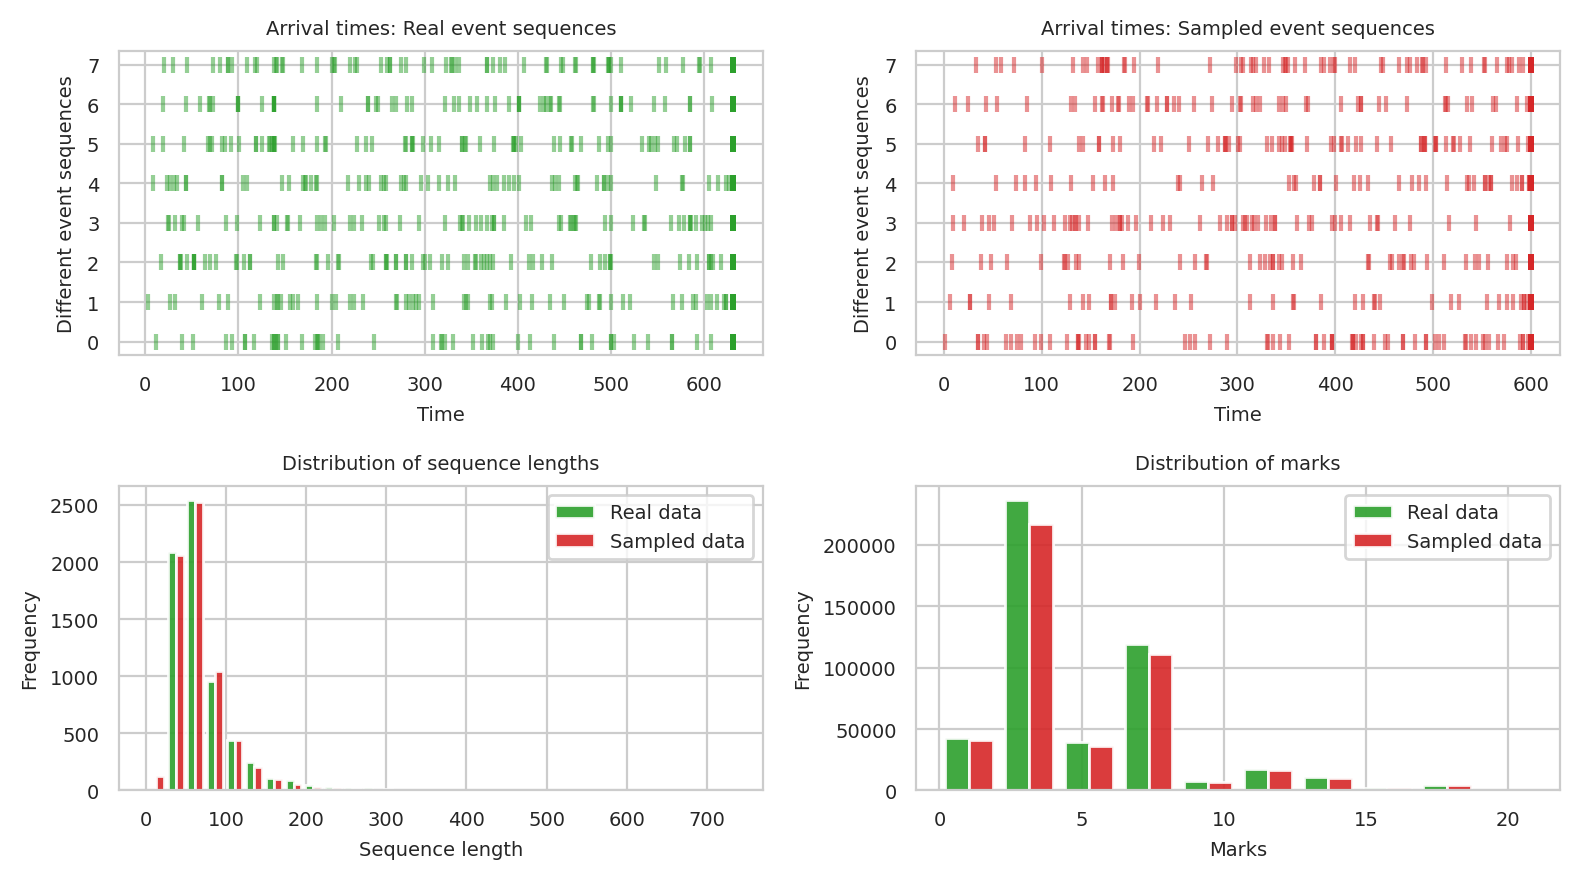

time: 1min 13s (started: 2022-08-20 09:47:21 +00:00)


In [14]:
dataset_name = 'real/stack_overflow' 

batch_size = 64                   # Number of sequences in a batch
num_mix_components = 64            # Number of components for a mixture model
context_size = 64                  # Size of the RNN hidden vector
mark_embedding_size = 32           # Size of the mark embedding (used as RNN input)
rnn_type = "GRU"                   # What RNN to use as an encoder {"RNN", "GRU", "LSTM"}
time_scale = 1e-5

# Sampling parameters Hawkes Dep
num_seq = 6633
t_start = 1.32e9 * time_scale
t_end = 1.38e9 * time_scale
t_end = t_end - t_start

params = {
            'dataset_name': dataset_name,
            'batch_size': batch_size, 
            'num_mix_components': num_mix_components,
            'context_size': context_size,
            'mark_embedding_size': mark_embedding_size,
            'rnn_type': rnn_type,
            'time_scale': time_scale,
            'num_seq': num_seq,
            't_end': t_end
        }

train_dataset(params)